# Package and deploy ML models outside Azure Machine Learning (Preview)

This notebook demonstrates how to create, register, and deploy a model to Azure Container Registry that can be run outside of the Azure Machine Learning service, for example, in Azure Container Apps.

For more information on this specific topic, see the [Package and deploy models outside Azure Machine Learning documentation](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-package-models-app-service?view=azureml-api-2&tabs=sdk).

The notebook also highlights how you can continue to use Managed Endpoints to deploy your containerized models.

> Note: This notebook is based on the [Azure ML Examples Quickstart notebook](https://github.com/Azure/azureml-examples/blob/main/tutorials/get-started-notebooks/quickstart.ipynb) for the purposes of providing a demonstration ML model to work with. Please refer to this notebook for further information on getting started with Azure Machine Learning.

## Prerequisites

The notebook requires a compute instance with the latest version of the Azure Machine Learning Python SDK installed. The [`setup\setup.sh`](./setup/setup.sh) script can be run on an existing compute instance to upgrade the library in the **Python 3.10 - SDK v2** environment.

> If you created your Azure Machine Learning environment using the [`infra\main.bicep`](../infra/main.bicep) template, a compute instance will be created for the running user with the script already run.

Ensure that the contents of this repo have been cloned into your Azure Machine Learning workspace to run the notebook using the **Python 3.10 - SDK v2** environment.

## 1. Setup handle for ML workspace

The following will configure a handle for the Azure Machine Learning workspace that will be used throughout the notebook. 

The **DefaultAzureCredential** will use the credentials of the user assigned to the compute instance running the notebook.

In [ ]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()
ml_client = MLClient.from_config(credential=credential)

ws = ml_client.workspaces.get(ml_client.workspace_name)
print(ws.name, ws.resource_group, ws.location, sep = '\n')  

## 2. Set Notebook variables

To be used throughout the Notebook, the following variables are set:

- `registered_model_name`: The name of the model to be registered in the Azure Machine Learning workspace.
- `deployment_name`: The name of the managed deployment used to deploy the managed endpoint.
- `endpoint_name`: The name of the managed endpoint used to deploy the model.

In [ ]:
import uuid

registered_model_name = "credit_defaults_model"
deployment_name = "blue"
endpoint_name = "credit-endpoint-" + str(uuid.uuid4())[:8]

## 3. Create a job to create and register a model

The following runs a general purpose **command** that takes the dataset from a public URL, trains a model, and registers it in the Azure Machine Learning workspace by running the [`src\main.py`](./src/main.py) script. 

The [environment](https://learn.microsoft.com/en-us/azure/machine-learning/concept-environments?view=azureml-api-2) used for the job is a standard out-of-the-box environment for executing the training. In the [Train a model tutorial](https://github.com/Azure/azureml-examples/blob/main/tutorials/get-started-notebooks/train-model.ipynb), you can learn how to create a custom environment for your own purposes.

In [ ]:
from azure.ai.ml import command
from azure.ai.ml import Input

job = command(
    inputs=dict(
        data=Input(
            type="uri_file",
            path="https://azuremlexamples.blob.core.windows.net/datasets/credit_card/default_of_credit_card_clients.csv",
        ),
        test_train_ratio=0.2,
        learning_rate=0.25,
        registered_model_name=registered_model_name,
    ),
    code="./src/",  # location of source code
    command="python main.py --data ${{inputs.data}} --test_train_ratio ${{inputs.test_train_ratio}} --learning_rate ${{inputs.learning_rate}} --registered_model_name ${{inputs.registered_model_name}}",
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    display_name="credit_default_prediction",
)

ml_client.create_or_update(job)

## 4. Get the model to containerize

Once the model has been registered with the Azure Machine Learning workspace, the following retrieves the latest registered model version so that it can be containerized.

In [ ]:
latest_model_version = max(
    [int(m.version) for m in ml_client.models.list(name=registered_model_name)]
)
print(f'Latest model is version "{latest_model_version}" ')

model = ml_client.models.get(name=registered_model_name, version=latest_model_version)

## 5. Package the model for deployment outside Azure Machine Learning

Deploying a model outside of Azure Machine Learning requires a package specification. To create a package that's completely disconnected from Azure Machine Learning, the `model_configuration` is set to `Copy`. This instructs the package to copy the model artifacts into the packaged container image so that it can be run outside of Azure Machine Learning.

> Note: As the model artifacts are copied into the container image, the image size will be larger than if the model artifacts were mounted into the container image.

In [ ]:
import time
from azure.ai.ml.entities import ModelPackage, AzureMLOnlineInferencingServer, ModelConfiguration

model_package_name = f"pkg-{model.name}-{model.version}"
model_package_version = str(int(time.time()))

package_config = ModelPackage(
    target_environment=model_package_name, 
    target_environment_version=model_package_version, 
    inferencing_server=AzureMLOnlineInferencingServer(), 
    model_configuration=ModelConfiguration(mode="Copy")
)

With the package specification set, the following creates the package that can be used to deploy the model outside of Azure Machine Learning.

In [ ]:
# Expect the package to take 5-10 minutes to create
model_package = ml_client.models.package(
    model.name, model.version, package_config
)

At this point, the model can be deployed to a container hosting service of your choosing, such as Azure Container Apps.

You can find the Azure Container Registry image for the model under **Environments > Custom environments > [model_package_name]** in the Azure Machine Learning workspace.

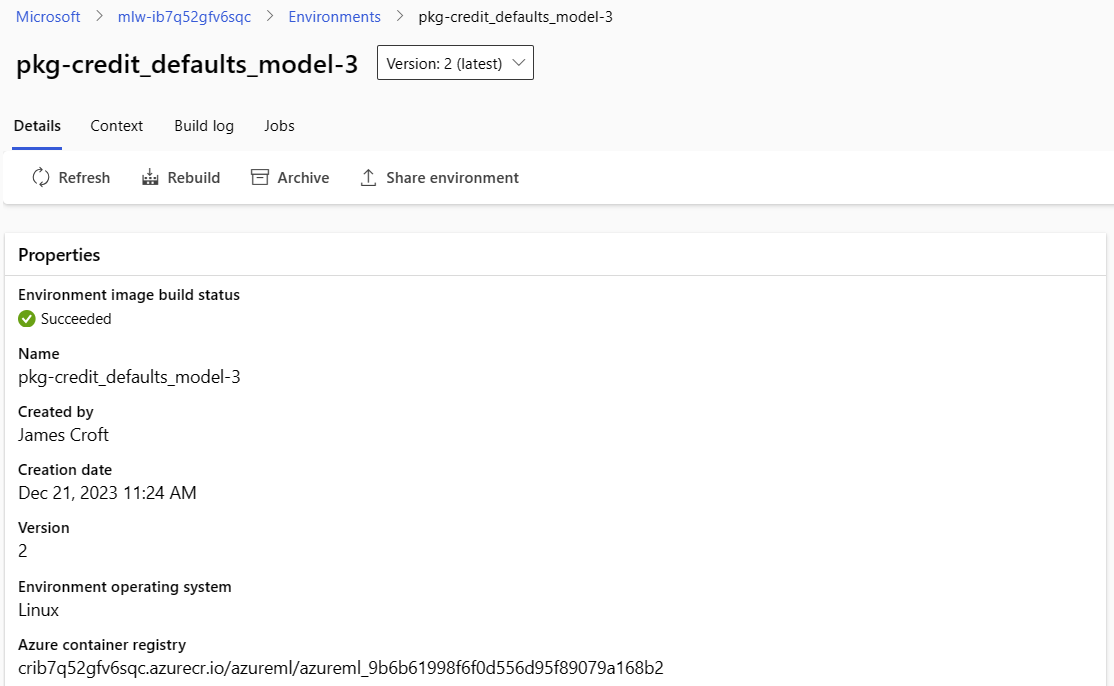

This can be referenced in your container hosting configuration to deploy the model outside of Azure Machine Learning.

**All following steps are optional and are used to demonstrate how you can continue to use Managed Endpoints to deploy your containerized models.**

## 6. (Optional) Create a managed endpoint for the model deployment

With the model packaged, the following creates a managed endpoint that can be used to host the model.

In [ ]:
# Expect the endpoint creation to take a few minutes
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment
)

# Create a managed endpoint
endpoint = ManagedOnlineEndpoint(
    name=endpoint_name,
    description="This is a managed endpoint for the credit default model",
    auth_mode="key",
    tags={
        "training_dataset": "credit_defaults",
        "model_type": "sklearn.GradientBoostingClassifier",
    },
)

endpoint = ml_client.online_endpoints.begin_create_or_update(endpoint).result()

print(f"Endpoint {endpoint.name} provisioning state: {endpoint.provisioning_state}")

## 7. (Optional) Deploy the model to the endpoint

Once the endpoint has been created, the following deploys the packaged model to the endpoint.

In [ ]:
# Expect this deployment to take approximately 5 to 10 minutes.
deployment = ManagedOnlineDeployment(
    name=deployment_name,
    endpoint_name=endpoint_name,
    environment=model_package,
    instance_count=1
)

deployment = ml_client.begin_create_or_update(deployment).result()

## 8. (Optional) Test the endpoint

Once the model is deployed to the endpoint, you can run inference with it.

The [`deploy\test_request.json`](./deploy/test_request.json) file contains a sample request that can be used to test the endpoint.

In [ ]:
ml_client.online_endpoints.invoke(
    endpoint_name=endpoint_name,
    request_file="./deploy/test_request.json",
    deployment_name=deployment_name,
)

## 9. (Optional) Cleanup

The following will delete the endpoint deployment created as part of this notebook.

In [ ]:
ml_client.online_endpoints.begin_delete(name=endpoint_name)